In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize


import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from typing import Union

# Grab data from data folder

In [2]:
def np_piece_data_from_csv(num, piece):
    filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}.csv' #performance number 1-6
    repo = pd.read_csv(filename,header=0)
    columns=['Frame', 'Time (Seconds)']
    repo = repo.drop(columns, axis=1)
    vals = repo.to_numpy(dtype=float)
    return repo, vals

# Useful shorthand

In [3]:
'''Column names of limbs that we care about atm:
- STRN
- LASI
- LSHO 
- LELB 
- LFIN
- LWRA
- LWRB'''

'''-------------CHOICES--------------'''
angLSHO = ["LASI","LSHO","LELB"]
angLELB = ["LSHO","LELB","LWRA"]
angLWRA = ["LELB","LWRA","LFIN"]
angRSHO = ["RASI","RSHO","RELB"]
angRELB = ["RSHO","RELB","RWRA"]
angRWRA = ["RELB","RWRA","RFIN"]

coarseness = 20 #min: 5 

#Frequency plotting things
angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to loop through
limbLST = ['LSHO','LELB','LWRA','RSHO','RELB','RWRA'] # list of angles to loop through

# Do stuff

In [4]:
#repeatedly needed

def getDegrees2D(repo, vals, POINTSx):
    '''Gets angle between three points ps=[p1,p2,p3] over all frames'''
    p1x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[0]+"x") # get the x,y,z data for each of the three points over all frames
    p2x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[1]+"x")
    p3x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[2]+"x")

    unit_vector = lambda x: normalize(x, axis = 1, norm = 'l2') # helper function to normalise vectors, anonymous function woah

    v1 = vals[:,p1x:p1x+3] - vals[:,p2x:p2x+3] # 3 points -> 2 vectors
    v2 = vals[:,p3x:p3x+3] - vals[:,p2x:p2x+3]
    v1_u = unit_vector(v1) # vectors -> unit vectors
    v2_u = unit_vector(v2)
    ang = np.rad2deg(np.arccos(np.sum(v1_u*v2_u, axis=1))) # calculate angle between vectors
    return(ang) 

In [5]:
def plot_degVStime2Ds(*data, **args):
    '''SINGLE DATASOURCE!! 
    For each triplet ps=[p1,p2,p3] in list, 
    plots angle between those three points ps_n over all n frames.'''
    repo,vals = data[0],data[1] #<'DataFrame'>,<'numpy.ndarray'>
    lisPOINTSx = args['lisPOINTSx']
    ln = vals.shape[0] # can change this if you don't want over the entire piece

    X = np.linspace(0, ln//240, ln) # x-axis for graph: frame # -> seconds 
    for count,POINTSx in enumerate(lisPOINTSx):
        ang = getDegrees2D(repo, vals, POINTSx)
        plt.plot(X,ang,alpha=0.5, label=count) # generate plot
    plt.ylabel("Degrees")
    plt.xlabel("Time (sec)")
    plt.legend()
    plt.show()

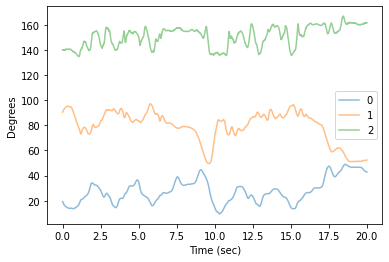

In [6]:
def main():
    piece = 3
    perf = 3
    repo,vals = np_piece_data_from_csv(perf,piece)
    angleBetweens = [["LASI","LSHO","LELB"],["LSHO","LELB","LWRA"],["LELB","LWRA","LFIN"]]
    
    plot_degVStime2Ds(repo, vals, lisPOINTSx = angleBetweens)

if __name__ == '__main__':
    main()

In [7]:
def standardize_len_attempt_1(lists: list[np.array]):
    x = lists[0]
    standardized_len_lists = []
    for lst in lists:
        #Stretch/compress y to be the length of first list
        xp = np.linspace(x[0], x[-1], len(lst))
        new_lst = np.interp(x, xp, lst) # interpolate the lst values at the new x values
        standardized_len_lists.append(new_lst) 
    return(standardized_len_lists)

def standardize_len(lists: list[np.array]):
    '''standardize the length of the arrays by interpolation 
    (sort of stretching them performances to all be the same length for ease of comparison)'''
    x = np.linspace(0, len(lists[0]) - 1, len(lists[0]))
    standardized_len_lists = []
    for lst in lists:
        #Stretch/compress y to be the length of first list
        xp = np.linspace(x[0], x[-1], len(lst))
        new_lst = np.interp(x, xp, lst) 
        standardized_len_lists.append(new_lst) 
    return(standardized_len_lists)

In [8]:
def plot_func(piece: Union[int, list[int]], perf: Union[int, list[int]], limb: list[str]) -> None:
    lisANGLES, lisLABELS = [], []

    cond = isinstance(piece, list)

    if cond:
        objects = piece
        lisLABELS_str = '_perf'
        title_func = lambda x, y, z: f'{x} for performance {y} over pieces {z}'
    else:
        objects = perf
        lisLABELS_str = '_piece'
        title_func = lambda x, y, z: f'{x} for piece {y} over performances {z}'

    for obj in objects:
        if cond: repo, vals = np_piece_data_from_csv(perf, obj)
        else: repo, vals = np_piece_data_from_csv(obj, piece)
        ang = getDegrees2D(repo, vals, POINTSx = limb)
        lisANGLES.append(ang)
        lisLABELS.append(f'{limb[1]}{lisLABELS_str}{obj}')

    if cond:
        plot_degVStime2Dm(lisANGLES, lisLABELS, title = title_func(limb[1], perf, objects))
    else:
        plot_degVStime2Dm(lisANGLES, lisLABELS, title = title_func(limb[1], piece, objects))


def plot_degVStime2Dm(*data, **args):
    '''MULTI DATASOURCE!! For each array in lisANGLES, 
    plot them over length of the longest array over time.
    Label each line by the corresponding label from lisLABELS.'''
    
    lisANGLES, lisLABELS = data[0], data[1]
    lisANGLES = standardize_len(lisANGLES)
    title = args.get('title', '') #.get: If the key is not found, the default value of an empty string is used

    plt.figure(figsize=(18, 5))
    for count,ang in enumerate(lisANGLES):
        ln = np.size(lisANGLES[count],0)
        X = np.linspace(0, ln//240, ln) # x-axis for graph: frame # -> seconds 
        plt.plot(X,ang,color=((6-count)/6,0.4,(count+1)/6,0.8), label=lisLABELS[count]) # generate plot
    plt.ylabel("Degrees")
    plt.xlabel("Time (sec)")
    plt.title(title)
    plt.legend()
    plt.show() #comment out when data is needed, not plot


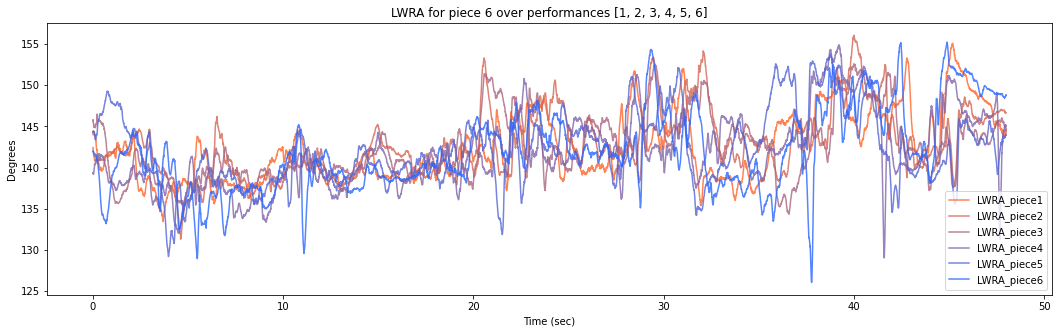

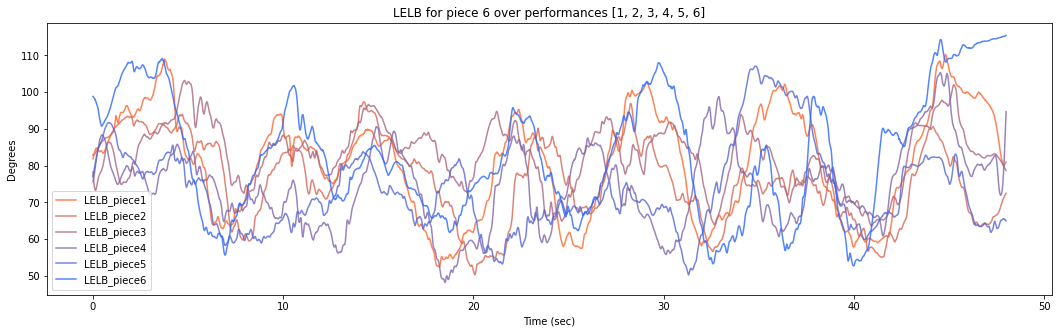

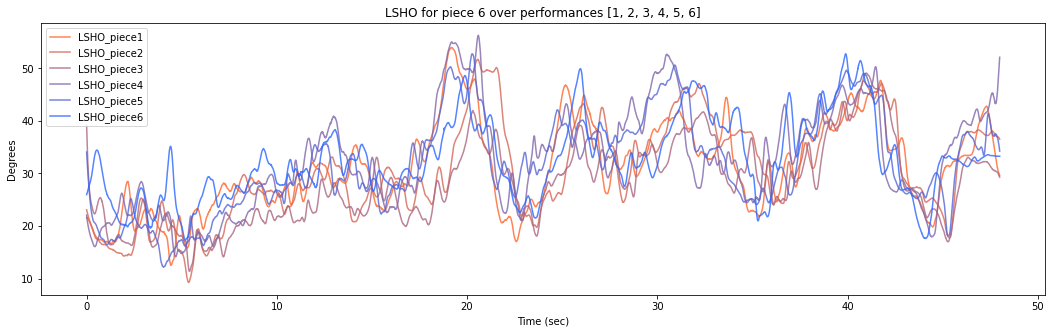

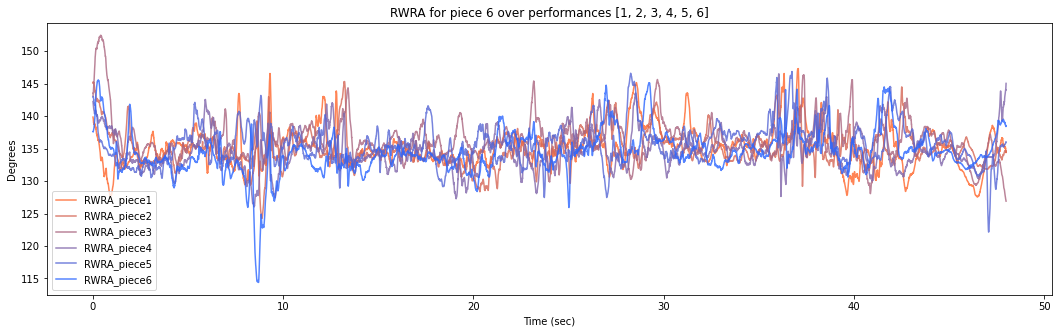

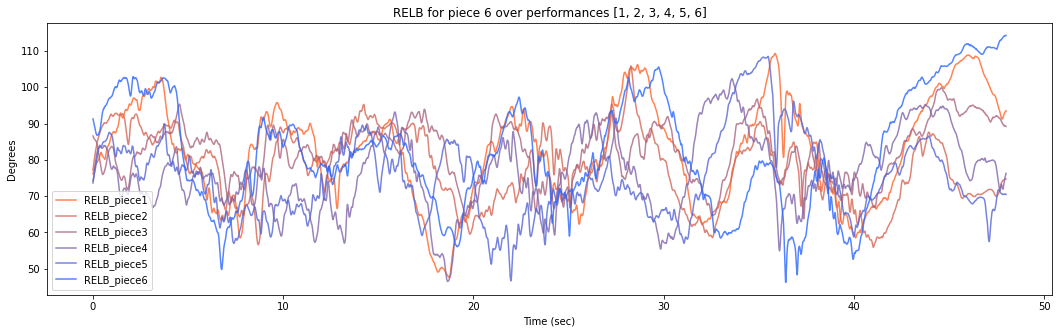

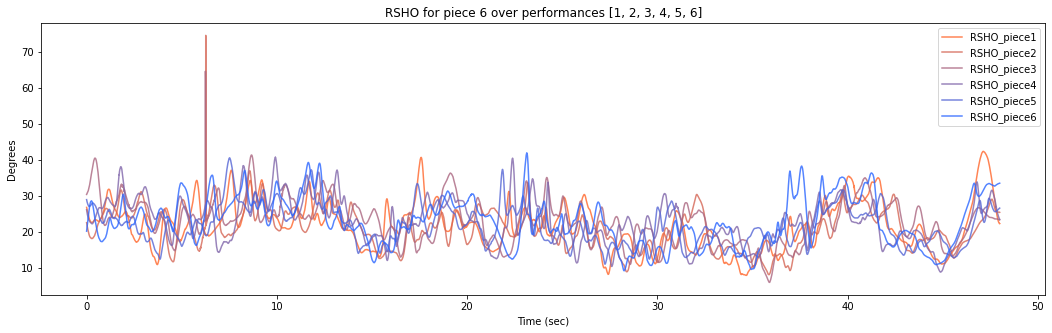

In [9]:
# run multi for perfs
def main():
    piece = 6 # can choose either multiple pieces or multiple performances for one limb
    perfs = [1,2,3,4,5,6]
    plot_func(piece, perfs, angLWRA) 
    plot_func(piece, perfs, angLELB) 
    plot_func(piece, perfs, angLSHO) 

    plot_func(piece, perfs, angRWRA) 
    plot_func(piece, perfs, angRELB) 
    plot_func(piece, perfs, angRSHO) 

if __name__ == '__main__':
    main()


In [10]:
def plot_degVSdeg2D(*data, **args):
    '''For each triplet ps=[p1,p2,p3] in list, plots angle between three points ps_n over all frames.'''
    repo,vals = np_piece_data_from_csv(data[0],data[1])
    lisPOINTSx = data[3] # the angle that all other angles will be compared to 
    xPOINTSx = lisPOINTSx[data[2]]
    title = args.get('title', '')
    X = getDegrees2D(repo, vals, xPOINTSx) # x-axis for graph
    for count,POINTSx in enumerate(lisPOINTSx):
        Y = getDegrees2D(repo, vals, POINTSx)
        plt.plot(X,Y,alpha=0.5, label=f'limb {count} vs {data[2]}') # generate plot
    plt.ylabel("Degrees")
    plt.xlabel("Degrees")
    plt.legend()
    plt.title(title)
    plt.show()

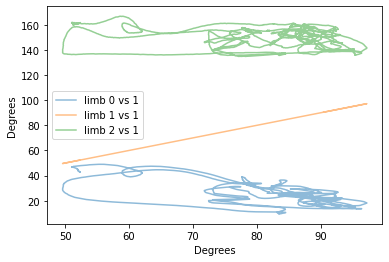

In [11]:
# run deg vs deg 2d
def main():
    piece = 3
    perf = 3
    limbLST = [["LASI","LSHO","LELB"],["LSHO","LELB","LWRA"],["LELB","LWRA","LFIN"]]
    limb = 1 # index of limbLST
    plot_degVSdeg2D(piece, perf, limb, limbLST, title = '')

if __name__ == '__main__':
    main()


# Weird ass thing, working for no reason. Ignore

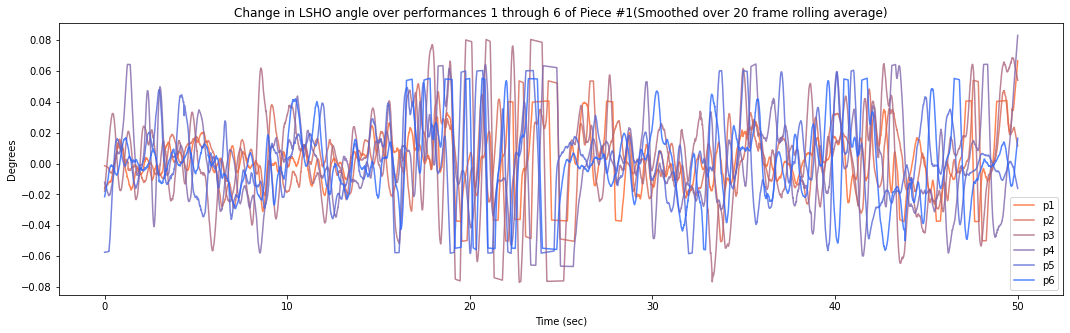

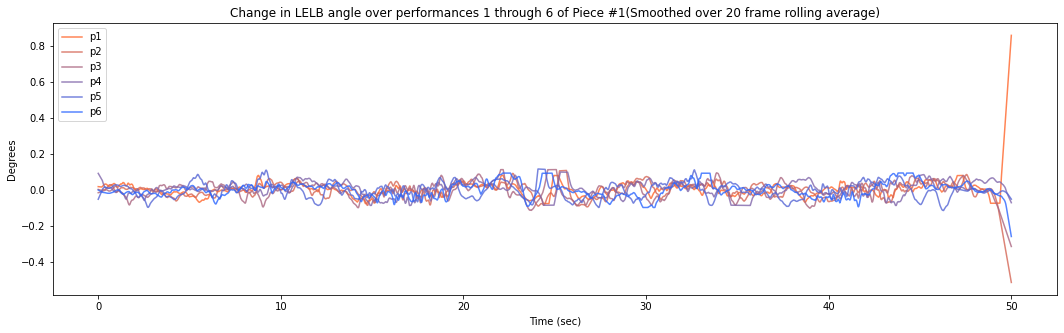

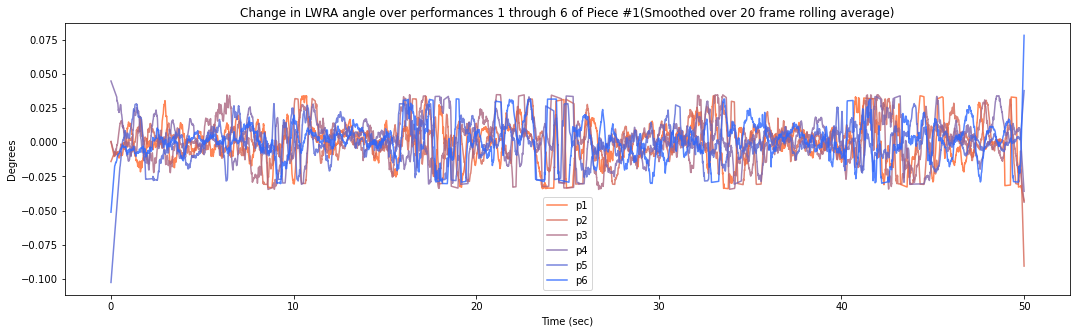

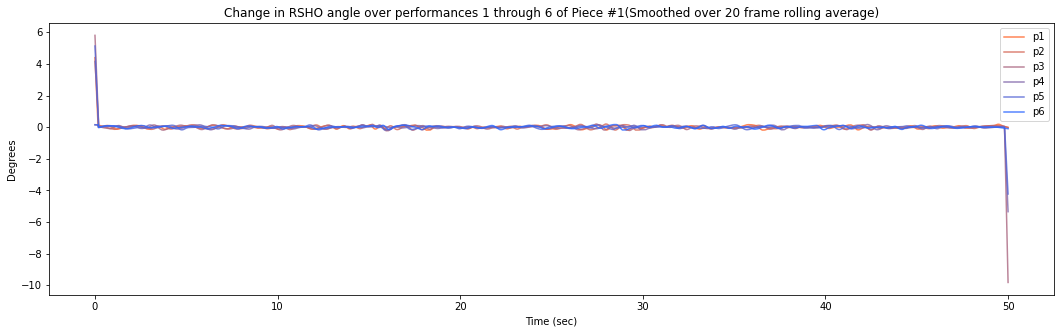

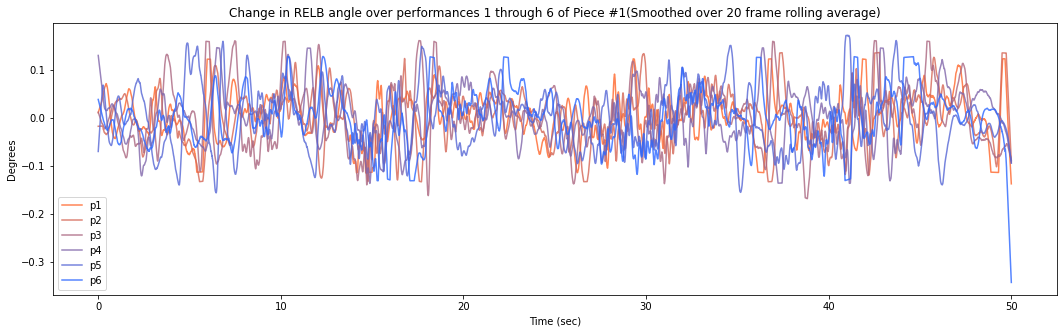

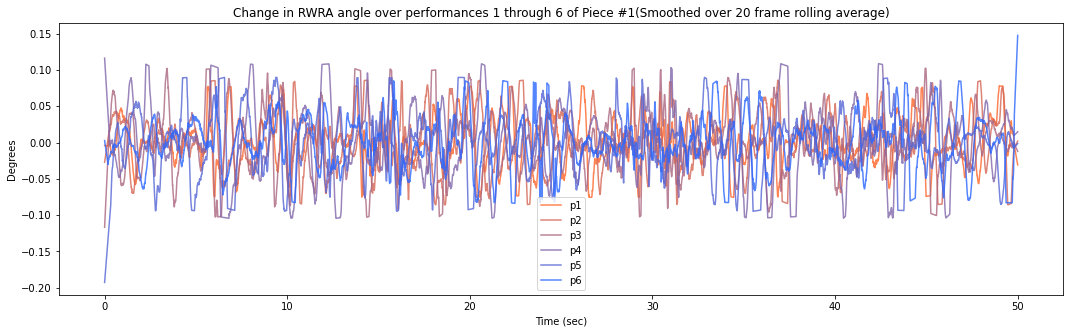

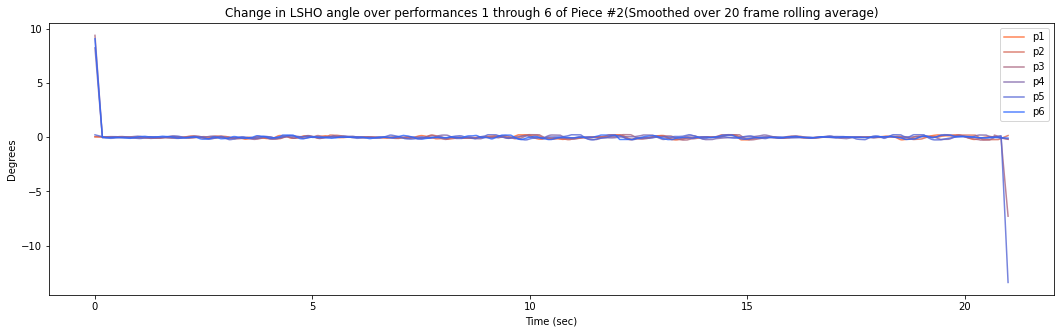

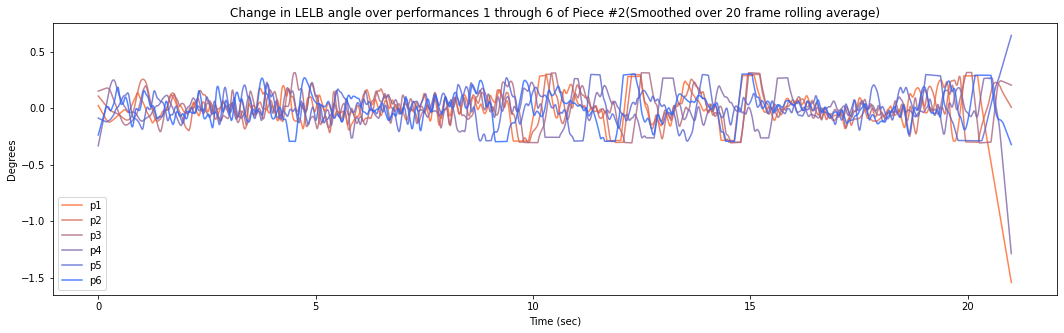

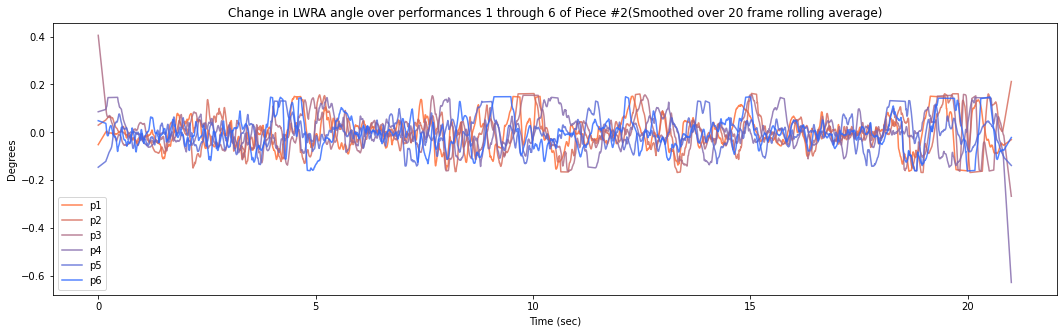

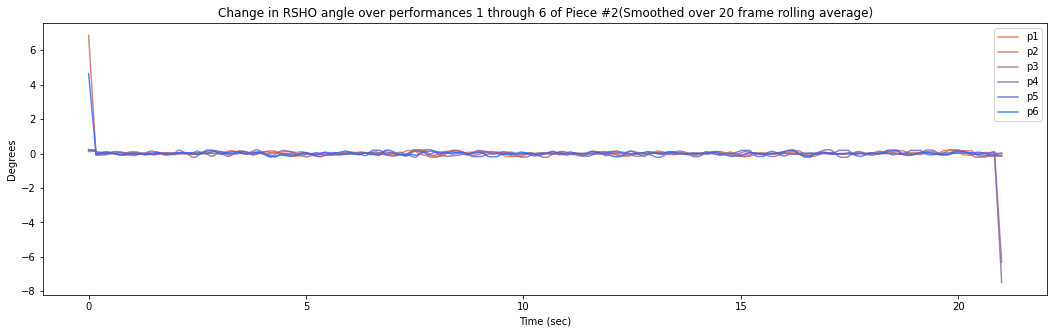

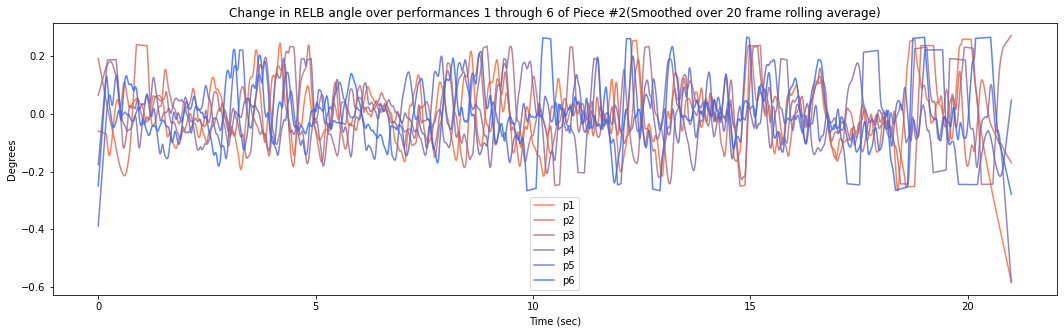

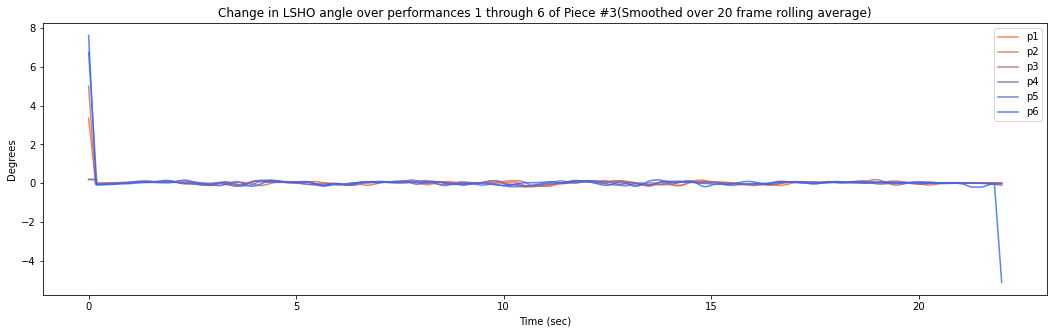

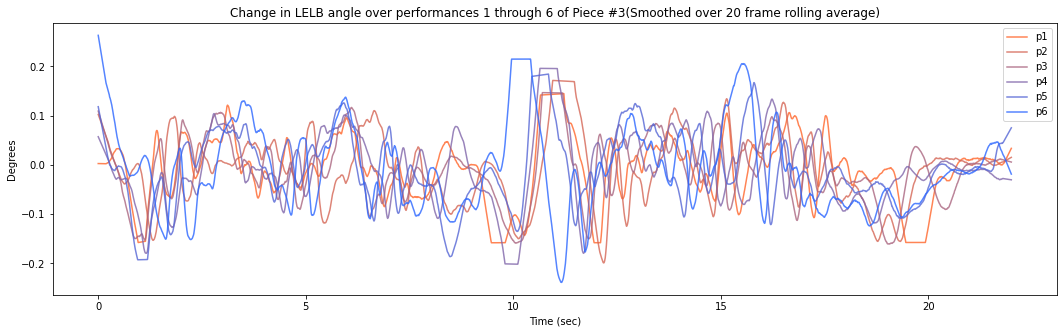

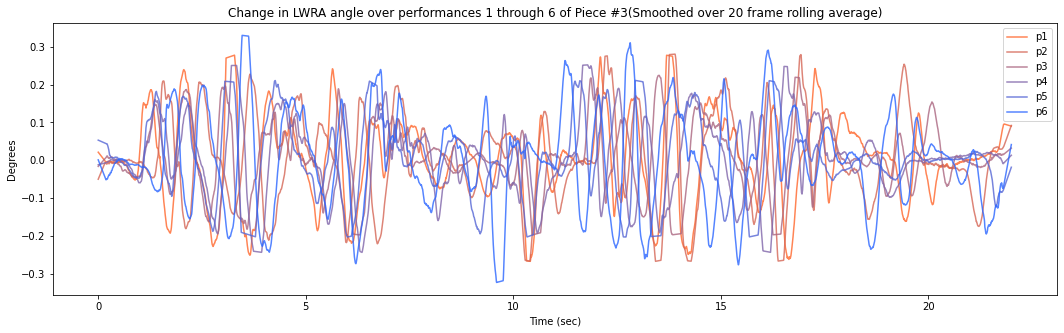

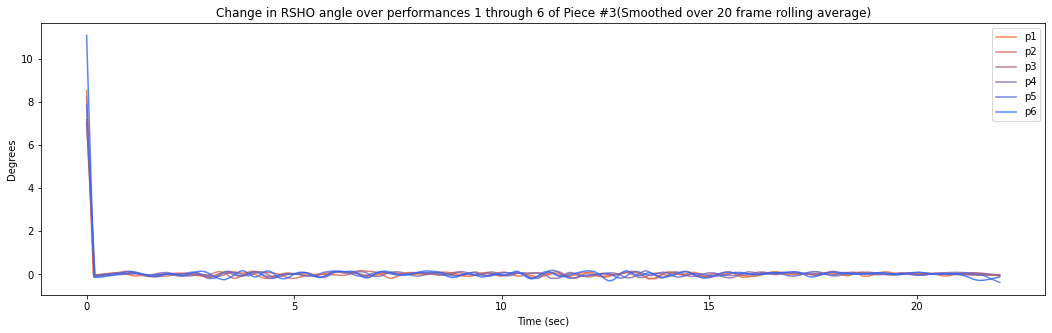

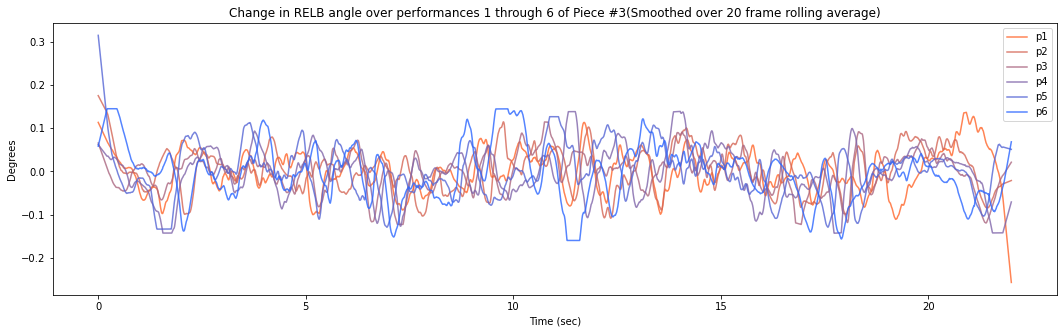

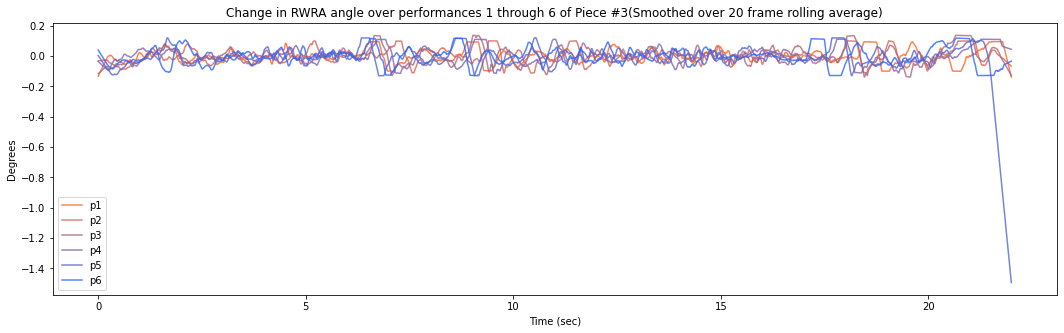

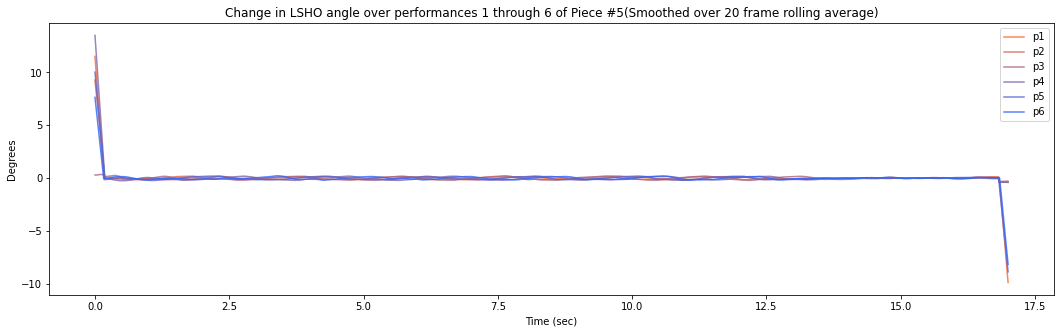

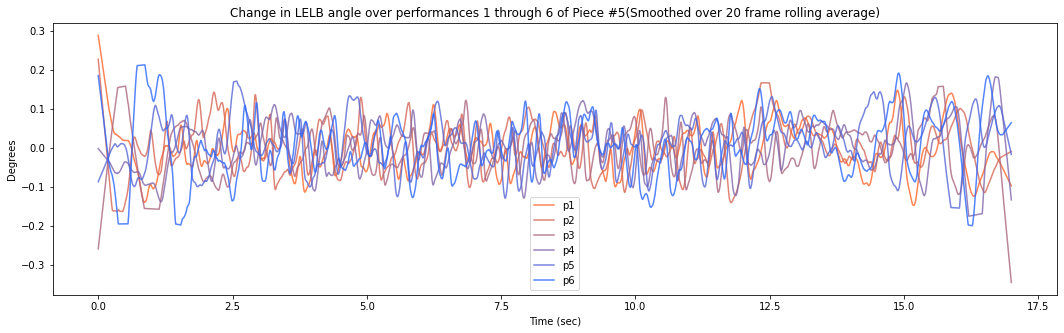

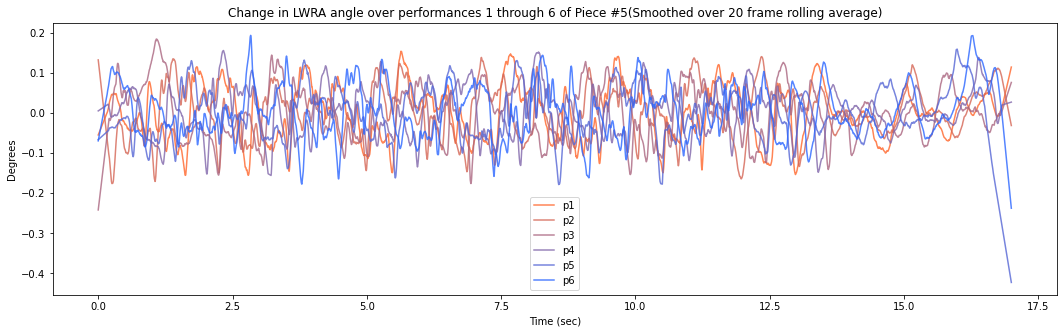

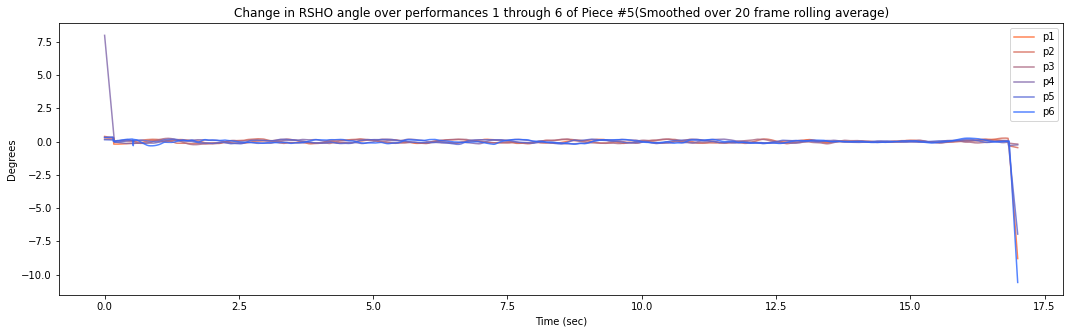

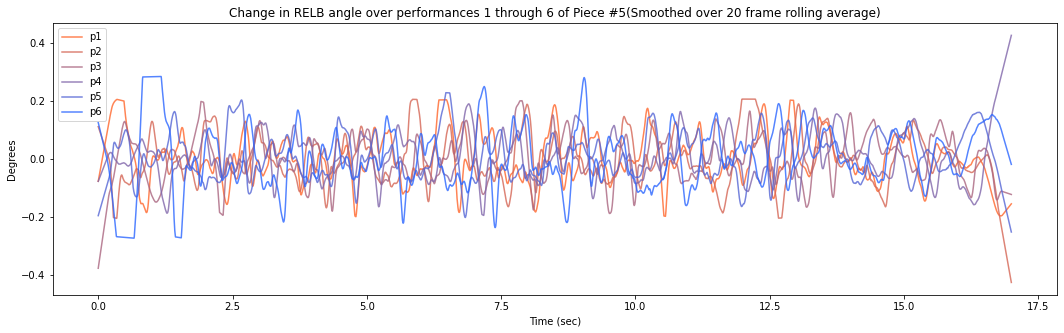

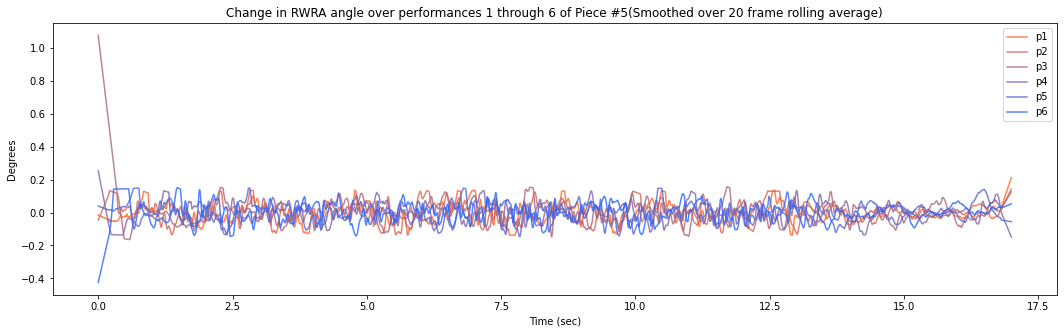

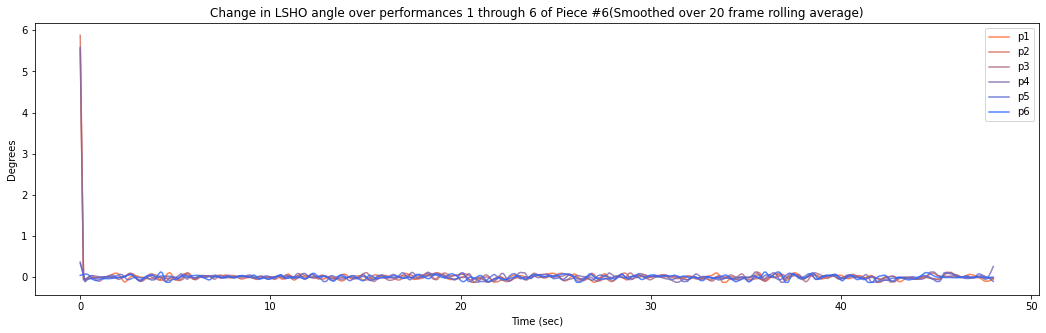

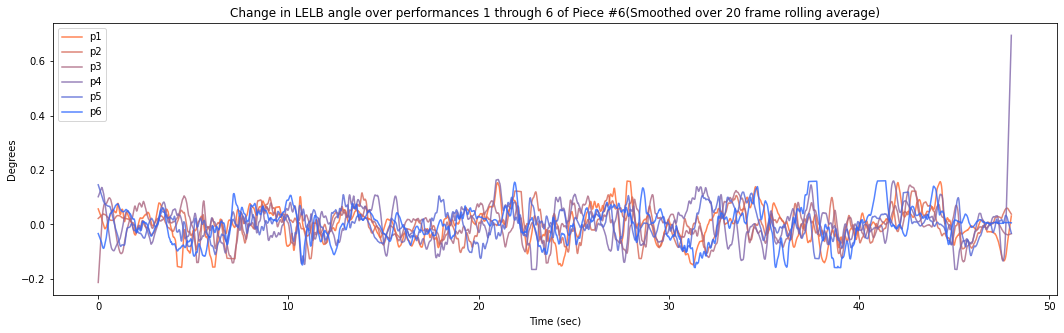

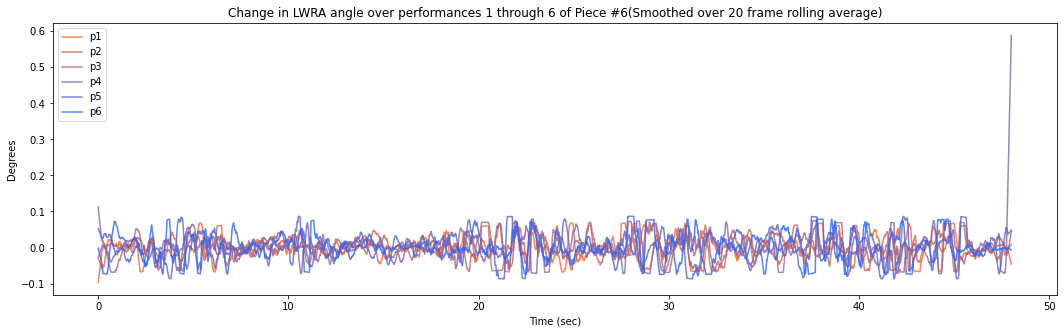

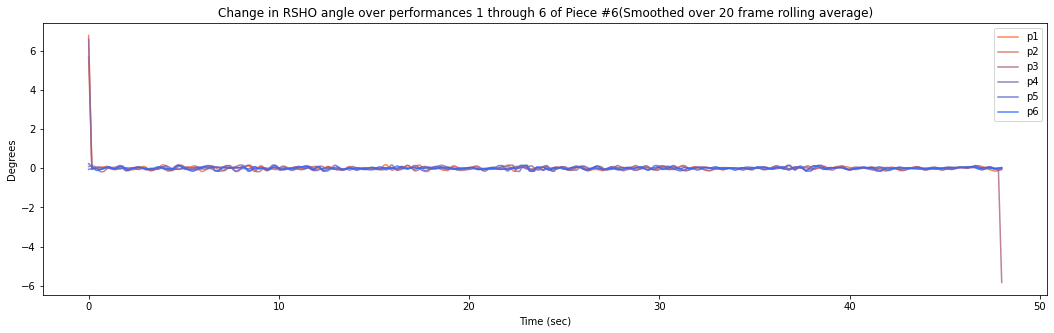

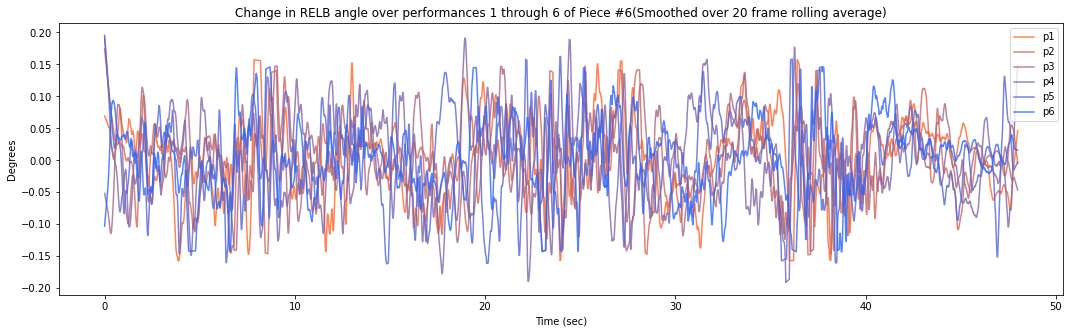

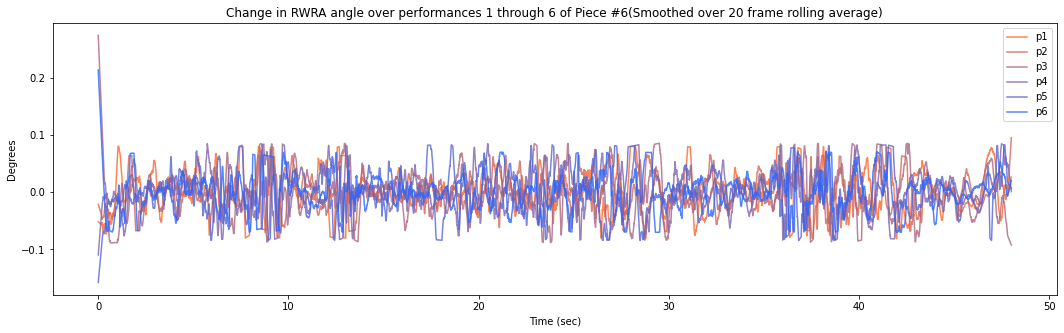

In [12]:
import sys
sys.path.append("..")
import csv_tangenting as t

# Smoothed-derivative plotting things?
for piece in [1,2,3,5,6]:
    angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to loop through
    # the 6 performances of a piece; repo(df) and vals(np array)
    p1,p2,p3,p4,p5,p6 = np_piece_data_from_csv(1,piece),np_piece_data_from_csv(2,piece),np_piece_data_from_csv(3,piece),np_piece_data_from_csv(4,piece),np_piece_data_from_csv(5,piece),np_piece_data_from_csv(6,piece) # the 6 performances of a piece; repo(df) and vals(np array)

    for ang in angLST:
        angpick = ang
        limbName = angpick[1]
        a1,a2,a3,a4,a5,a6 = getDegrees2D(p1[0], p1[1], angpick),getDegrees2D(p2[0], p2[1], angpick),getDegrees2D(p3[0], p3[1], angpick),getDegrees2D(p4[0], p4[1], angpick),getDegrees2D(p5[0], p5[1], angpick),getDegrees2D(p6[0], p6[1], angpick)
        arrayLST = [a1,a2,a3,a4,a5,a6]
        [a1,a2,a3,a4,a5,a6] = t.callDeriv(arrayLST,smoothed=True)
        title = "Change in "+limbName+" angle over performances 1 through 6 of Piece #"+str(piece)+ "(Smoothed over 80 frame rolling average)"
        pl = plot_degVStime2Dm([a1,a2,a3,a4,a5,a6], ['p1','p2','p3','p4','p5','p6'], title=title)
 
        plt.show()
        #plt.savefig('/Users/HAQbook/Desktop/graaaaphs/d20_'+limbName+'ang_piece'+str(piece)+'_2D.png')
